In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
sentiment = pd.read_csv("G:/Trader-sentiment-analysis/Data/fear_greed_index.csv")
trades = pd.read_csv("G:/Trader-sentiment-analysis/Data/historical_data.csv")


In [8]:
print(sentiment.shape)
print(trades.shape)

print(sentiment.isnull().sum())
print(trades.isnull().sum())

print(sentiment.duplicated().sum())
print(trades.duplicated().sum())


(2644, 4)
(211224, 16)
timestamp         0
value             0
classification    0
date              0
dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
0
0


In [14]:
print(sentiment.head())
print(sentiment.columns)


    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05
Index(['timestamp', 'value', 'classification', 'date'], dtype='str')


In [16]:
print(trades.columns)
print(trades.head())


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='str')
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3

In [18]:
# Clean column names first (important)
trades.columns = trades.columns.str.strip()
sentiment.columns = sentiment.columns.str.strip()

# Convert sentiment date
sentiment["date"] = pd.to_datetime(sentiment["date"])
sentiment["date"] = sentiment["date"].dt.date

# Convert trade timestamp (YOUR actual column name)
trades["Timestamp IST"] = pd.to_datetime(
    trades["Timestamp IST"],
    dayfirst=True
)


# Create daily date column in trades
trades["date"] = trades["Timestamp IST"].dt.date




In [20]:
merged = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

merged["classification"].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [22]:
daily_pnl = merged.groupby(["Account","date"])["Closed PnL"].sum().reset_index()


In [25]:
merged["win"] = merged["Closed PnL"] > 0


win_rate = merged.groupby(["Account","date"])["win"].mean().reset_index()


In [27]:
trades_per_day = merged.groupby(["Account","date"]).size().reset_index(name="trade_count")


In [34]:
median_size = merged["Size USD"].median()

merged["size_segment"] = merged["Size USD"].apply(
    lambda x: "High Size" if x > median_size else "Low Size"
)


In [35]:
merged.groupby(["classification","size_segment"])["Closed PnL"].mean()


classification  size_segment
Extreme Fear    High Size        61.196379
                Low Size          1.157202
Extreme Greed   High Size       140.570044
                Low Size          9.628661
Fear            High Size        97.025581
                Low Size          3.580906
Greed           High Size        84.301244
                Low Size          3.609685
Neutral         High Size        69.581271
                Low Size          2.188668
Name: Closed PnL, dtype: float64

In [37]:
long_short = merged.groupby(["classification","Side"]).size().unstack(fill_value=0)

long_short


Side,BUY,SELL
classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


In [41]:
merged.groupby("classification")["Closed PnL"].mean()


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64

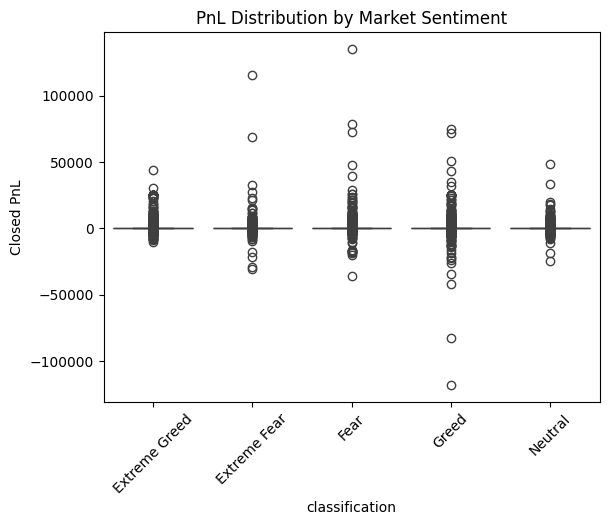

In [43]:
sns.boxplot(data=merged, x="classification", y="Closed PnL")
plt.xticks(rotation=45)
plt.title("PnL Distribution by Market Sentiment")
plt.show()


In [45]:
# Average PnL
merged.groupby("classification")["Closed PnL"].mean()

# Average Trade Size
merged.groupby("classification")["Size USD"].mean()

# Trade Frequency
merged.groupby("classification").size()


classification
Extreme Fear     21400
Extreme Greed    39992
Fear             61837
Greed            50303
Neutral          37686
dtype: int64

In [46]:
merged.groupby("classification")["Closed PnL"].std()


classification
Extreme Fear     1136.056091
Extreme Greed     766.828294
Fear              935.355438
Greed            1116.028390
Neutral           517.122220
Name: Closed PnL, dtype: float64

In [48]:
median_size = merged["Size USD"].median()

merged["size_segment"] = np.where(
    merged["Size USD"] > median_size,
    "High Size",
    "Low Size"
)


In [49]:
merged.groupby(["classification","size_segment"])["Closed PnL"].mean()


classification  size_segment
Extreme Fear    High Size        61.196379
                Low Size          1.157202
Extreme Greed   High Size       140.570044
                Low Size          9.628661
Fear            High Size        97.025581
                Low Size          3.580906
Greed           High Size        84.301244
                Low Size          3.609685
Neutral         High Size        69.581271
                Low Size          2.188668
Name: Closed PnL, dtype: float64

In [51]:
freq = merged.groupby("Account").size()
threshold = freq.median()

merged["freq_segment"] = merged["Account"].map(
    lambda x: "Frequent" if freq[x] > threshold else "Infrequent"
)


In [53]:
account_winrate = merged.groupby("Account")["win"].mean()

In [54]:
merged["consistency_segment"] = merged["Account"].map(
    lambda x: "Consistent" if account_winrate[x] > 0.6 else "Inconsistent"
)


In [55]:
merged.groupby(["classification","consistency_segment"])["Closed PnL"].mean()


classification  consistency_segment
Extreme Fear    Consistent             81.243158
                Inconsistent           33.837859
Extreme Greed   Consistent             55.005705
                Inconsistent           69.258164
Fear            Consistent             29.666031
                Inconsistent           54.971352
Greed           Consistent             36.645300
                Inconsistent           43.078366
Neutral         Consistent             -1.780025
                Inconsistent           35.766292
Name: Closed PnL, dtype: float64

In [56]:
merged.groupby("classification")["Closed PnL"].std()


classification
Extreme Fear     1136.056091
Extreme Greed     766.828294
Fear              935.355438
Greed            1116.028390
Neutral           517.122220
Name: Closed PnL, dtype: float64

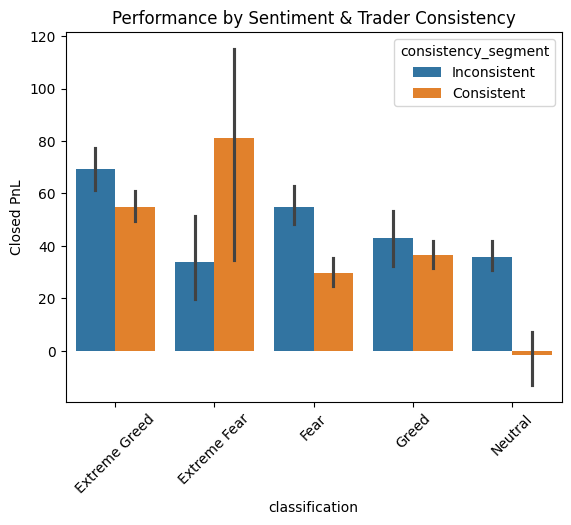

In [57]:
sns.barplot(
    data=merged,
    x="classification",
    y="Closed PnL",
    hue="consistency_segment"
)
plt.xticks(rotation=45)
plt.title("Performance by Sentiment & Trader Consistency")
plt.show()
